<style>
    @media print{
        body {
            position:relative !important;
        }
        .celltag_new_page {
            page-break-before: always !important;
        }
    }
</style>
# COMPSCI 371 Homework 7

_**Group Members:**_ Ethan Goldberg, Noah Costa, Charlie Oestreicher

### Problem 0 (3 points)

## Part 1: The Bootstrap Sampler

### Problem 1.1

In [10]:
import numpy as np

def sample(n, shape, gen):
    # yes, this function could be one line,
    # but this is far more readable.
    m = np.prod(shape)
    random_integers = gen.choice(n, size=m, replace=True)
    result = random_integers.reshape(shape)
    return result

rng = np.random.default_rng(15)
sample(5, (2, 7), rng)

array([[4, 3, 3, 4, 1, 1, 1],
       [0, 2, 2, 4, 0, 4, 3]])

### Problem 1.2 (Exam Style)

$V_1 = \{0,1,5,6,8\}$

### Problem 1.3

When N = 10 and R = 10000:
  m_hat_M / N = 0.35
  sigma_hat_M / N = 0.1
  m_M / N = 0.35
  sigma_M / N = 0.15

When N = 31 and R = 10000:
  m_hat_M / N = 0.36
  sigma_hat_M / N = 0.056
  m_M / N = 0.36
  sigma_M / N = 0.086

When N = 100 and R = 10000:
  m_hat_M / N = 0.37
  sigma_hat_M / N = 0.031
  m_M / N = 0.37
  sigma_M / N = 0.048

When N = 316 and R = 10000:
  m_hat_M / N = 0.37
  sigma_hat_M / N = 0.017
  m_M / N = 0.37
  sigma_M / N = 0.027

When N = 1000 and R = 10000:
  m_hat_M / N = 0.37
  sigma_hat_M / N = 0.0099
  m_M / N = 0.37
  sigma_M / N = 0.015



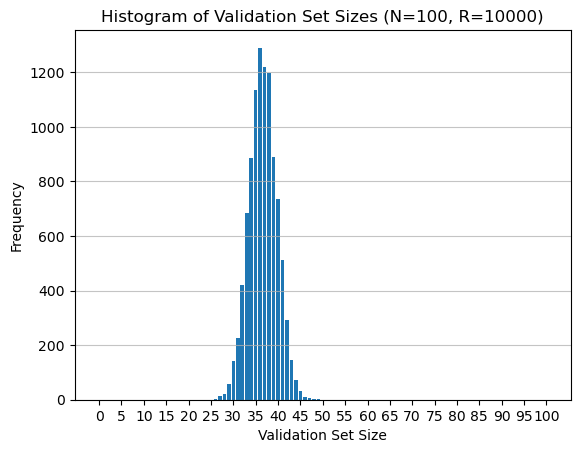

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def generate_bootstrap_validation_sets(N, R):
    rng = np.random.default_rng(15)
    training_bags = sample(N, (R, N), rng)
    training_set = np.arange(N)  # Create the original training set.
    validation_sets = [np.setdiff1d(training_set, training_bag) for training_bag in training_bags]
    validation_lengths = [len(validation_set) for validation_set in validation_sets]

    m_hat_M = np.mean(validation_lengths)
    sigma_hat_M = np.std(validation_lengths)
    
    p = (1-(1/N))**N
    m_M = p*N
    sigma_M = np.sqrt(N*p*(1-p))
    
    return validation_lengths, m_hat_M, sigma_hat_M, m_M, sigma_M

def show_graph(validation_lengths, N):
    plt.hist(validation_lengths, bins=range(N + 2), align='left', rwidth=0.8)
    plt.title(f'Histogram of Validation Set Sizes (N={N}, R={R})')
    plt.xlabel('Validation Set Size')
    plt.ylabel('Frequency')
    x_labels = range(0, N+1, 5)  # Labels every 10 units
    plt.xticks(x_labels)
    plt.grid(axis='y', alpha=0.75)

R = 10000
for N in np.logspace(1,3,num=5,dtype=int):
    validation_lengths, m_hat_M, sigma_hat_M, m_M, sigma_M = generate_bootstrap_validation_sets(N,R)
    print("{}\n{}\n{}\n{}\n{}\n".format(
        f"When N = {N} and R = {R}:", 
        f"  m_hat_M / N = {m_hat_M/N:.2g}", 
        f"  sigma_hat_M / N = {sigma_hat_M/N:.2g}",
        f"  m_M / N = {m_M/N:.2g}",
        f"  sigma_M / N = {sigma_M/N:.2g}"))
    if N == 100:
        show_graph(validation_lengths, N)

### Problem 1.4

The empirical mean ratios are consistent with the statistical mean ratios. The empirical standard deviation ratios are not consistent with the statistical standard deviation ratios.

### Problem 1.5 (Exam Style)

## Part 2: Cross-Validation with the Bootstrap

### Problem 2.1

In [8]:
from sklearn.linear_model import LogisticRegression
import numpy as np
from matplotlib import pyplot as plt
from time import time
from tqdm import tqdm

In [12]:
def bootstrap_validation(t, c_values, n_folds, rng):
    n = len(t.y)
    # n_v = n // n_folds
    all_idx = set(np.arange(n, dtype=int))
    best_c, best_accuracy, best_variance = None, -np.inf, None
    c_accuracies = []
    for c in tqdm(c_values):
        # v_idx = np.arange(n_v)
        s, s2 = 0., 0.
        for fold in range(n_folds):
            # t_idx = np.array(list(all_idx - set(v_idx)), dtype=int)
            t_idx = sample(n, (n,), rng)
            v_idx = np.setdiff1d(list(all_idx), t_idx)
            h = LogisticRegression(C=c, max_iter=10000)
            h.fit(t.x[t_idx], t.y[t_idx])
            acc = h.score(t.x[v_idx], t.y[v_idx])
            s, s2 = s + acc, s2 + acc ** 2
        accuracy = s / n_folds
        c_accuracies.append(accuracy)
        if accuracy > best_accuracy:
            variance = (s2 - accuracy * s) / (n_folds - 1)
            best_c, best_accuracy, best_variance = c, accuracy, variance
    best_h = LogisticRegression(C=best_c, max_iter=10000)
    best_h.fit(t.x, t.y)
    return best_h, best_accuracy, best_variance, c_accuracies

In [27]:
from sklearn.linear_model import LogisticRegression
import numpy as np

def bootstrap_validation_best(t, c_values, n_folds, rng):
    n = len(t.y)
    k = len(c_values)
    all_idx = np.arange(n, dtype=int)
    s, s2 = np.zeros(k), np.zeros(k)

    for fold in range(n_folds):
        t_idx = sample(n, (n,), rng)
        v_idx = np.setdiff1d(all_idx, t_idx)

        for i, c in enumerate(c_values):
            h = LogisticRegression(C=c, max_iter=10000)
            h.fit(t.x[t_idx], t.y[t_idx])
            acc = h.score(t.x[v_idx], t.y[v_idx])
            s[i] += acc
            s2[i] += acc ** 2

    best_c_idx = np.argmax(s)
    best_c = c_values[best_c_idx]
    best_accuracy = s[best_c_idx] / n_folds
    best_variance = (s2[best_c_idx] - best_accuracy * s[best_c_idx]) / (n_folds - 1)

    best_h = LogisticRegression(C=best_c, max_iter=10000)
    best_h.fit(t.x, t.y)

    return best_h, best_accuracy, best_variance, s / n_folds


In [22]:
def experiment(c_range=np.logspace(-3, 3, num=20), n_folds=5):
    rng = np.random.default_rng(15)
    start = time()
    clf, val_acc, val_acc_variance, c_acc = bootstrap_validation_best(
        mnist.train, c_range, n_folds, rng
    )
    stop = time()
    test_accuracy = clf.score(mnist.test.x, mnist.test.y)

    print('time for bootstrap validation {:.1f} seconds'.format(stop - start))
    plt.figure()
    plt.semilogx(c_range, c_acc)
    plt.xlabel('C'), plt.ylabel('validation accuracy')
    print('best c: {:.4g}'.format(clf.C))
    print('validation accuracy and variance: {:.4g}, {:.4g}'.format(val_acc, val_acc_variance))
    print('test accuracy {:.4f}'.format(test_accuracy))
    plt.show()

In [23]:
import urllib.request
import ssl
from os import path as osp
import shutil

In [24]:
def retrieve(file_name, semester='fall23', homework=7):
    if osp.exists(file_name):
        print('Using previously downloaded file {}'.format(file_name))
    else:
        context = ssl._create_unverified_context()
        fmt = 'https://www2.cs.duke.edu/courses/{}/compsci371/homework/{}/{}'
        url = fmt.format(semester, homework, file_name)
        with urllib.request.urlopen(url, context=context) as response:
            with open(file_name, 'wb') as file:
                shutil.copyfileobj(response, file)
        print('Downloaded file {}'.format(file_name))

In [25]:
import pickle

file_name = 'mnist.pickle'
retrieve(file_name, homework=2)

with open(file_name, 'rb') as file:
    mnist = pickle.load(file)

Using previously downloaded file mnist.pickle


time for bootstrap validation 36.1 seconds
best c: 1.438
validation accuracy and variance: 0.8477, 0.0002626
test accuracy 0.8625


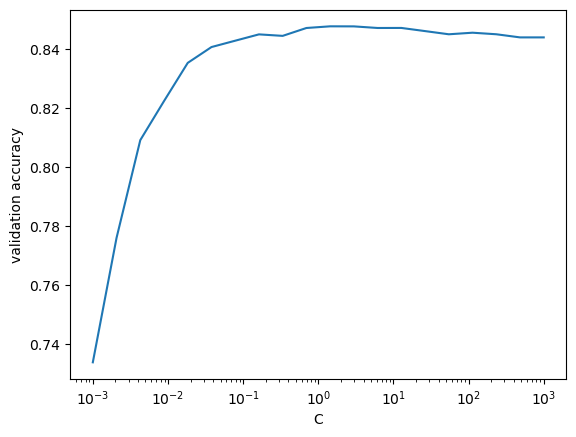

In [28]:
experiment()

### Problem 2.2 (Exam Style)

No, it does not necessarily mean that the corresponding choice of best_c is better. This is our accuracy over the training set, not on our validation set. It does not mean that we will generalize better to unseen data just because our accuracy is better, because for best_accuracay we are using the empirical mean, rather than the statistical one.

## Part 3: Basics of Linear Support Vector Machines 

### Problem 3.1 (Exam Style)

## Part 4: Binary Linear SVMs and LRCs

### Problem 4.1 (Exam Style)

### Problem 4.2

In [ ]:
balanced_file_name = 'balanced.pickle'
retrieve(balanced_file_name)

Using previously downloaded file balanced.pickle


In [ ]:
with open(balanced_file_name, 'rb') as file:
    balanced_data = pickle.load(file)

In [ ]:
def show_data(data, title):
    fs = 12
    x, y = data.x, data.y
    labels, colors = (-1, 1), ('r', 'b')
    for label, color in zip(labels, colors):
        k = y == label
        plt.plot(x[k, 0], x[k, 1], 'o' + color,
                 label='y = {}'.format(label), ms=3)
    plt.legend(fontsize=fs)
    plt.axis('equal')
    plt.axis('off')
    plt.title(title, fontsize=fs)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline


def draw_line(b, w, style):
    xlim, ylim = plt.xlim(), plt.ylim()
    if np.abs(w[0]) > np.abs(w[1]):
        xs = np.array(xlim) + np.array([-1, 1])
        ys = (-b - w[0] * xs) / w[1]
    else:
        ys = np.array(ylim) + np.array([-1, 1])
        xs = (-b - w[1] * ys) / w[0]
    plt.plot(xs, ys, style, c='k')
    plt.xlim(xlim)
    plt.ylim(ylim)

Comments:
- (i) The datasets (train and test) are not linearly separable, and accuracy is therefore less than 100 percent.
- (ii) Both classifiers generalize well, and in fact achieve testing accuracy that is slightly _greater_ than their training accuracy.
- (iii) The two classifiers achieve equal performance on both the training set and the test set. Visually, they appear to compute the exact same boundary.

### Problem 4.3

In [ ]:
imbalanced_file_name = 'imbalanced.pickle'
retrieve(imbalanced_file_name)

Using previously downloaded file imbalanced.pickle


In [ ]:
with open(imbalanced_file_name, 'rb') as file:
    imbalanced_data = pickle.load(file)